In [1]:
import matplotlib.pyplot as plt

#set path to image
# path="mask_spam2017V2r1_SSA_A_COCO_A.tif"
path='../data/spam2017V2r1_SSA_P_COCO_A.tif'

tiff = plt.imread(path)

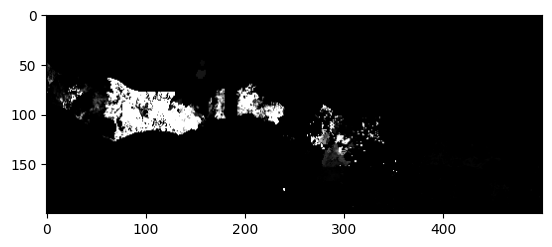

In [2]:
plt.imshow(tiff[900:1100,2000:2500, :])

In [3]:
tiff.shape

(2160, 4320, 4)

In [4]:
from osgeo import gdal
ds = gdal.Open(path)
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

/Users/neu/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
minx, maxx, miny, maxy

(-180.0, 179.99856, -89.99928, 90.0)

In [6]:
ds.RasterXSize, ds.RasterYSize, gt

(4320, 2160, (-180.0, 0.083333, 0.0, 90.0, 0.0, -0.083333))

In [7]:
from osgeo import osr

old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 

#get the coordinates in lat long
latlong = transform.TransformPoint(minx,miny) 

In [8]:
latlong

(-180.0, -89.99928, 0.0)

In [9]:
col, row, band = ds.RasterXSize, ds.RasterYSize, ds.RasterCount
xoff, a, b, yoff, d, e = ds.GetGeoTransform()
print(xoff, a, b, yoff, d, e)

-180.0 0.083333 0.0 90.0 0.0 -0.083333


In [10]:
def pixel2coord(x, y):
    """Returns global coordinates from coordinates x,y of the pixel"""
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)

In [11]:
x,y = pixel2coord(col/2,row/2)
print (x, y)

-0.0007200000000011642 0.0003600000000005821


In [12]:
# get the existing coordinate system
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs)

In [13]:
# converting into geographic coordinate system
lonx, latx, z = transform.TransformPoint(x,y)
print (latx, lonx, z)

0.0003600000000005821 -0.0007200000000011642 0.0


In [14]:
# rb = ds.GetRasterBand(1)
px,py = col/2,row/2                   # the pixel location
pix = ds.ReadAsArray(px,py,1,1)     
print(pix[0][0])                        # pixel value

-1.0


In [15]:
import rasterio

#Alternatively Open IMage with rasterio
dataset_rasterio = rasterio.open(path)

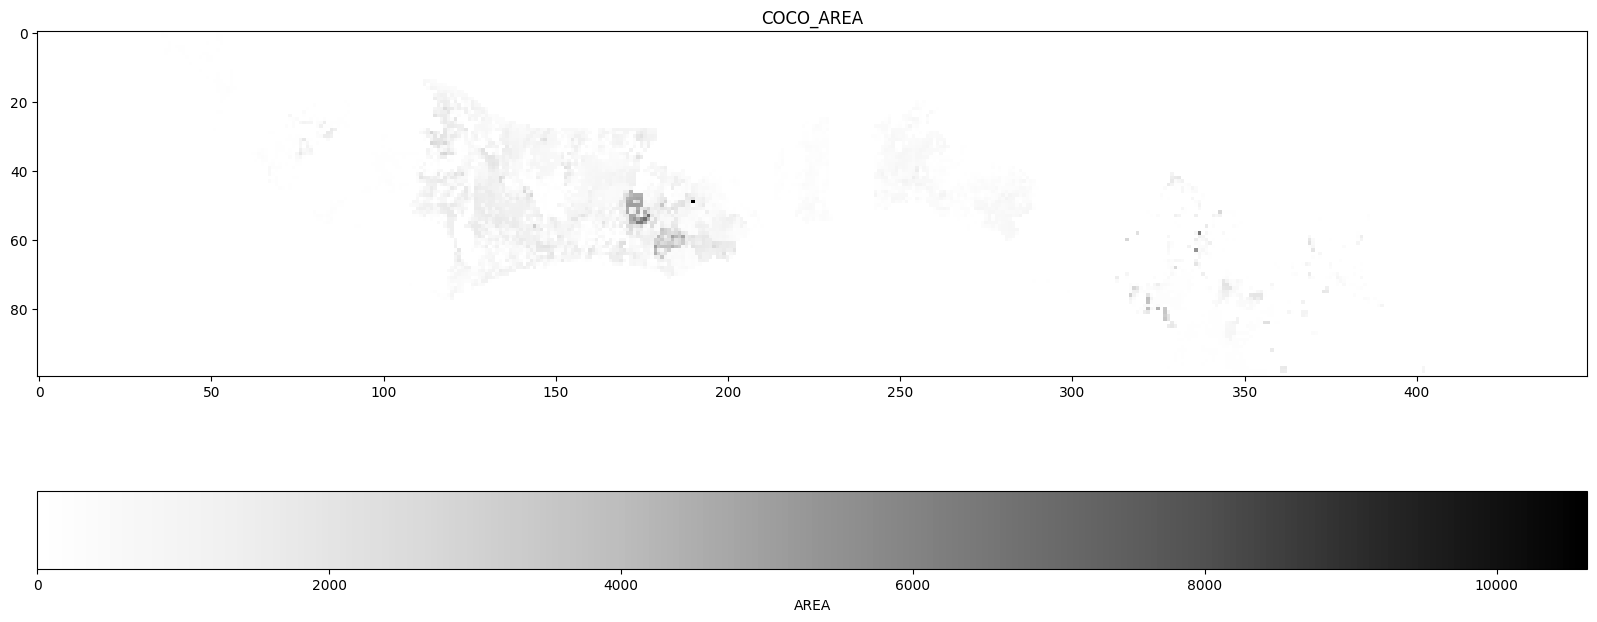

In [16]:
# Read the raster data
data = ds.ReadAsArray()

x_min = 950
x_max = 1050
y_min = 1950
y_max = 2400
     
     
# Plot the raster data using matplotlib
plt.figure(figsize=(20,10)) 
plt.imshow(data[x_min:x_max, y_min:y_max], cmap='Greys')
plt.title('COCO_AREA')
plt.colorbar(label='AREA', location = 'bottom')
plt.show()

In [17]:
data[x_min:x_max, y_min:y_max].max()

10622.2

In [19]:
# from ipywidgets import interact

# @interact
# def f_lambda(x):
#     return 5000 if (x>5000) else x

import ipywidgets as widgets
import numpy as np

top_range = widgets.IntSlider(
    value=5000,
    min=data[x_min:x_max, y_min:y_max].min(),
    max=data[x_min:x_max, y_min:y_max].max(),
)

# @widgets.interact_manual(top_range=(data[x_min:x_max, y_min:y_max].min(), data[x_min:x_max, y_min:y_max].max()))
f = lambda x: top_range.value if(x > top_range.value) else x

f_vec = np.vectorize(f)
top_range


IntSlider(value=5000, max=10622, min=-1)

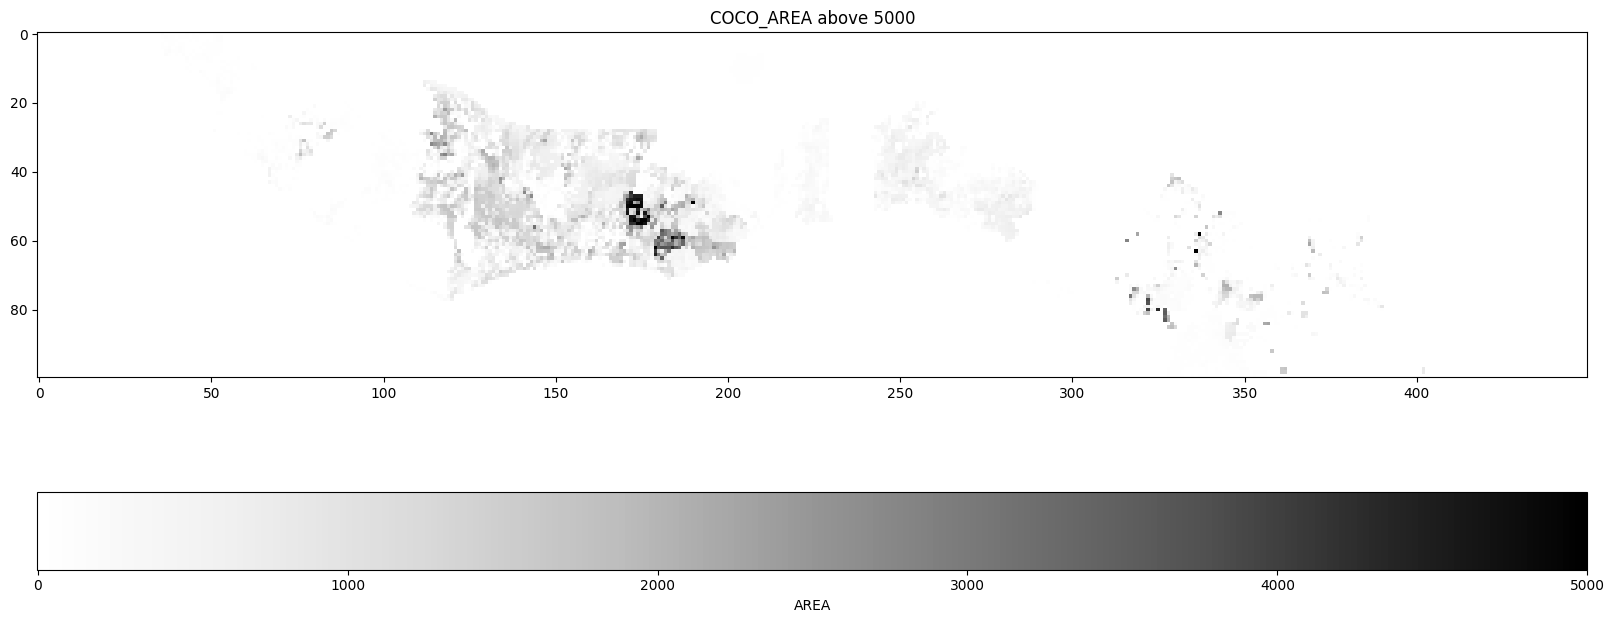

Number of pixels: 9 / (100, 450)


In [20]:
# Plot the raster data using matplotlib
sub_data = f_vec(data[x_min:x_max, y_min:y_max])
plt.figure(figsize=(20,10)) 
plt.imshow(sub_data, cmap='Greys')
plt.title(f'COCO_AREA above {top_range.value}')
plt.colorbar(label='AREA', location = 'bottom')
plt.show()

print(f'Number of pixels: {np.sum(sub_data==top_range.value)} / {sub_data.shape}')

In [53]:
from ipywidgets import interact
import numpy as n

@interact(top_range=widgets.IntSlider(
    value=5000,
    min=data[x_min:x_max, y_min:y_max].min(),
    max=data[x_min:x_max, y_min:y_max].max())
         )
def g(top_range):
    # @widgets.interact_manual(top_range=(data[x_min:x_max, y_min:y_max].min(), data[x_min:x_max, y_min:y_max].max()))
    f = lambda x: top_range if(x > top_range) else x

    f_vec = np.vectorize(f)

    # Plot the raster data using matplotlib
    sub_data = f_vec(data[x_min:x_max, y_min:y_max])
    plt.figure(figsize=(20,10)) 
    plt.imshow(sub_data, cmap='Greys')
    plt.title(f'COCO_AREA above {top_range}')
    plt.colorbar(label='AREA', location = 'bottom')
    plt.show()

    print(f'Number of pixels: {np.sum(sub_data==top_range)} / {sub_data.shape}')

interactive(children=(IntSlider(value=5000, description='top_range', max=10622, min=-1), Output()), _dom_class…

In [52]:
@interact(top_vals=widgets.IntSlider(
    value=10,
    min=0,
    max=data[x_min:x_max, y_min:y_max].shape[0] * data[x_min:x_max, y_min:y_max].shape[1])
         )
def get_top_vals(top_vals):
    def largest_indices(ary, n):
        """Returns the n largest indices from a numpy array."""
        flat = ary.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, ary.shape)

    sub_data = data[x_min:x_max, y_min:y_max]
    index_array = largest_indices(sub_data, top_vals)
    print(f'top {top_vals} values: \n{sub_data[index_array]} \nat indices \n{index_array}')

interactive(children=(IntSlider(value=10, description='top_vals', max=45000), Output()), _dom_classes=('widget…

In [26]:
def K_means_images(dataset, n_clusters, best_classes):
    # Read the raster data
    data = dataset.read()

    # Reshape to one channel
    reshaped_data = data.reshape(-1, 1)

    # k-means clustering 
    #n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
    cluster_labels = kmeans.labels_
    
    # Reshape the clustered labels back to the original image shape
    clustered_image = cluster_labels.reshape(data.shape)
    
    # Find the two most dominant clusters
    dominant_clusters = np.argsort(np.bincount(cluster_labels))[::-1][:2]
    '''didnt added best_classes, as value to control the count of the best taken classes'''

    # Mask the image to keep only pixels corresponding to the two dominant clusters
    masked_image = np.where(np.isin(clustered_image, dominant_clusters), clustered_image, np.nan)

    # Squeeze dimension in the data array
    #data_squeezed = np.squeeze(data)

    # Return both Images
    return data, clustered_image, masked_image

import numpy as np
from sklearn.cluster import KMeans

#call k_means_images
original, kmeans, best = K_means_images(dataset_rasterio,6,2)

In [23]:
np.unique(kmeans), np.unique(best)

NameError: name 'kmeans' is not defined

NameError: name 'kmeans' is not defined

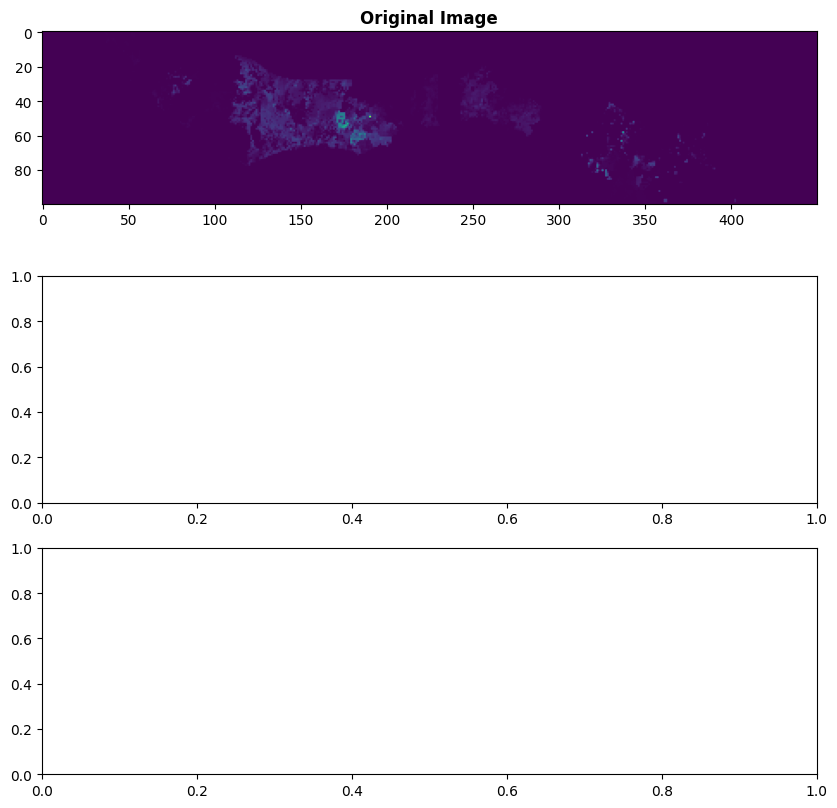

In [22]:
from rasterio.plot import show
#lets plot it 

# Plot the original and clustered images side by side
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

x_min = 950
x_max = 1050
y_min = 1950
y_max = 2400

# Original image
show(data[x_min:x_max, y_min:y_max], ax=ax1, cmap='viridis', title='Original Image')

# Clustered image
show(kmeans[:, x_min:x_max, y_min:y_max], ax=ax2, cmap='viridis', title='K-Means Clustering (k=6)')

# masked image
show(best[:, x_min:x_max, y_min:y_max], ax=ax3, cmap='viridis', title='Two dominant classes')

# Add colorbar 
cbar = fig.colorbar(ax3.images[0], ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('')

plt.tight_layout()
plt.show()


#plt.show()